---
title: "Using The Excel Object Model in Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
description: "Programmatically interact with Excel using `pandas`, `xlwings`, and `pywin32`."
date: "2025-3-12"
image: thumbnail.png
draft: true
categories: ['Python', 'Data Management']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [257]:
import pandas as pd
import numpy as np
import xlwings as xw
import os

In this post, I'm going to overview how to use Python's `xlwings` and `pywin32` libraries to produce formatted, human-readable tables in Excel. Beyond basic uses of `xlwings`, I'll overview how to leverage `pywin32` and the `.api` attribute to interact directly with the Excel object model using VBA-like Python code. The apporach allows one to produce highly custommizable Excel tables that should satisfy any audience that prefers formatted spreadsheet output.

Alongside this blog post, I've been developing an `excel` submodule in my `swiss-code` package, with various wrapper functions for `xlwings` and `pywin32`. I'll showcase some of those functions here as well.  

## Problem Setup

In [258]:
#| code-fold: true
def simulate_df(num_transactions=1000):
    np.random.seed(1)
    customer_ids = np.random.randint(1000, 5000, num_transactions)
    transaction_amounts = np.round(np.random.uniform(5, 500, num_transactions), 2)
    payment_methods = np.random.choice(["Credit Card", "Debit Card", "PayPal", "Cash"], num_transactions)
    categories = np.random.choice(["Electronics", "Clothing", "Groceries", "Entertainment"], num_transactions)
    transaction_dates = pd.date_range(start="2024-01-01", periods=num_transactions, freq="D")
    data = {
        "transaction_id": range(1, num_transactions + 1),
        "customer_id": customer_ids,
        "amount": transaction_amounts,
        "payment_method": payment_methods,
        "category": categories,
        "date": transaction_dates
    }

    df = pd.DataFrame(data)
    return df

Say we have a dataset of customer transactions at a department store. I simulated this data arbitrarily.

In [259]:
df = simulate_df()
df.head()

,transaction_id,customer_id,amount,payment_method,category,date
0,1,2061,177.75,Debit Card,Electronics,2024-01-01
1,2,1235,33.20,Credit Card,Clothing,2024-01-02
2,3,4980,118.26,Credit Card,Groceries,2024-01-03
3,4,2096,333.73,Debit Card,Entertainment,2024-01-04
4,5,4839,251.14,Credit Card,Electronics,2024-01-05


Let's imagine the case where a stakeholder asks for a report on total dollars transacted, broken down by key categories and payment method. It's fairly straightforward to use `pandas` to make an attractive pivot table that can serve as such a report, complete with human-readable, title-cased indices and columns. In this case, I've aggregated the total dollars spent, dissagregated by payment method and category of good.

In [260]:
dollars_by_method = df.pivot_table(
    index="payment_method",
    columns="category",
    values="amount",
    aggfunc="sum"
)
dollars_by_method.index.name = "Payment Method"
dollars_by_method.columns.name = 'Category'
dollars_by_method

Category,Clothing,Electronics,Entertainment,Groceries
Payment Method,,,,
Cash,15016.00,17026.47,18208.16,18242.88
Credit Card,16074.92,10960.64,16052.85,20187.25
Debit Card,14032.23,17325.96,14363.99,17188.67
PayPal,14143.84,15108.84,16852.17,12065.14


Some users may prefer that the pivot table also include subtotals, and we can flexibly add those for both independent variables by leveraging the axis argument in `df.sum()`

In [261]:
dollars_by_method.loc[:, 'Total'] = dollars_by_method.sum(axis=1)
dollars_by_method.loc['Total', :] = dollars_by_method.sum(axis=0)
dollars_by_method

Category,Clothing,Electronics,Entertainment,Groceries,Total
Payment Method,,,,,
Cash,15016.00,17026.47,18208.16,18242.88,68493.51
Credit Card,16074.92,10960.64,16052.85,20187.25,63275.66
Debit Card,14032.23,17325.96,14363.99,17188.67,62910.85
PayPal,14143.84,15108.84,16852.17,12065.14,58169.99
Total,59266.99,60421.91,65477.17,67683.94,252850.01


That's a fine-enough `pandas` dataframe, but now the question arises of how to best serve this data to the end-user.  

There are several options -- lately I've been using Quarto reports or else Tableau dashboards for these sorts of analytics projects. However, those formats are very "finalized" and can be a little unsatisfying for end-users who want to further filter or modify table output. If that audience doesn't use R/Python, access to underlying `.ipynb` or `.qmd` files will not be helpful. This is the case where I think that spreadsheet output, and specifically reproducible, formatted Excel worksheets, can be very potent.

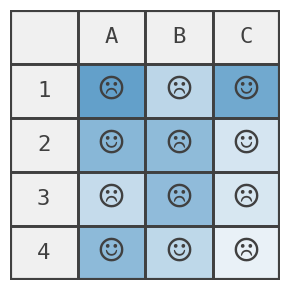

In [262]:
#| echo: false
#| output: false

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(2)
rows, cols = 4, 3
data = np.random.randint(100, 999, size=(rows, cols))
fig, ax = plt.subplots(figsize=(3, 3))

for i in range(rows + 1):
    for j in range(cols + 1):
        # Header row (letters)
        if i == 0:
            text = chr(65 + j - 1) if j > 0 else ""  # A, B, C, etc.
            color = "#404040"
            bgcolor = (.816, .816, .816, .3)
            fontsize=16
        # Index column (numbers)
        elif j == 0:
            text = str(i)
            color = "#404040"
            bgcolor = (.816, .816, .816, .3)
            fontsize=16
        else:
            text = np.random.choice(["☺", "☹"])
            color = "#404040"
            bgcolor = (.122, .467, .706, np.random.uniform()) # Alternating row colors
            fontsize=30
        ax.add_patch(
            plt.Rectangle((j, rows - i), 1, 1, fc=bgcolor, ec="#404040", lw=2)
            )
        ax.text(j + 0.5, rows - i + 0.5, text, ha="center", va="center", 
                fontsize=fontsize, fontfamily="monospace", color=color)
        
ax.add_patch(plt.Rectangle((0, 0), cols + 1, rows + 1, fill=False, edgecolor="#404040", lw=3))
ax.set_xlim(0, cols + 1)
ax.set_ylim(0, rows + 1)
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.tight_layout()
fig.savefig('thumbnail.png', dpi=300)

## Writing data to Excel

To write a `pandas` dataframe out to Excel, we'll first establish an `xw.Book` object, which either creates or opens an existing excel file, in this case `test.xlsx`.

In [263]:
filename = "test.xlsx"
if os.path.exists(filename):
        wb = xw.Book(filename)
else:
    wb = xw.Book()
    wb.save(filename)
wb

<Book [test.xlsx]>

Next, we establish a sheet within that `xw.Book`, in this case `first_test`.

In [264]:
sheet_name = 'first_test'
try:
    sheet_new = wb.sheets.add(sheet_name) 
except ValueError:
    sheet_new = wb.sheets[sheet_name]
sheet_new

<Sheet [test.xlsx]first_test>

At this point, we can select the sheet, `sheet_new`, select a start range, `A1`, then set it's value with our dataframe object, `dollars_by_method`. This will export the full dataframe into the spreadsheet.

In [265]:
sheet_new.range("A1").options(index=True, header=True).value = dollars_by_method

Then, when we save the book, we can inspect the output.

In [266]:
wb.save()

![](1.png)

This is a fairly unattractive table, with no formatting and with poorly fitted columns. This is also equivalent to what we could get if we simply used the `df.to_excel()` method within `pandas`. We'll proceed to formatting this table, where we get the real value out of `xlwings`.

## Interacting with the Excel Object Model

The most powerful aspect of `xlwings` is easily interacting with the Excel object model -- an API that allows for programmatically editing Excel spreadsheets. One would typically interact with Excel's object model via VBA code, but `xlwings` and `pywin32` together allow for us to use Python instead. Microsoft provides a clear overview of the object model concept [in the "VBA Programming 101"](https://learn.microsoft.com/en-us/office/vba/library-reference/concepts/getting-started-with-vba-in-office#vba-programming-101) section of the Official VBA Reference, and a complete reference for the [Excel object model](https://learn.microsoft.com/en-us/office/vba/api/overview/excel/object-model) in the Excel VBA Reference.

![Excel Object Model for VBA Reference](object_model.png){width=80%}

For example, here I'll call the `.api` attribute for the whole sheet:

In [267]:
sheet_new.api

<win32com.gen_py.Microsoft Excel 16.0 Object Library._Worksheet instance at 0x1492679989520>

This is an instance of the Worksheet object, which has [a documentation page in Excel's VBA reference](https://learn.microsoft.com/en-us/office/vba/api/excel.worksheet).  

![The Worksheet Object](worksheet.png){width=80%}

The Worksheet object has a property, UsedRange, which is the range 

In [268]:
sheet_new.api.UsedRange

<win32com.gen_py.Microsoft Excel 16.0 Object Library.Range instance at 0x1492702371504>

The UsedRange https://learn.microsoft.com/en-us/office/vba/api/excel.range.entirecolumn

In [269]:
sheet_new.api.UsedRange.EntireColumn

<win32com.gen_py.Microsoft Excel 16.0 Object Library.Range instance at 0x1492702385584>

https://learn.microsoft.com/en-us/office/vba/api/excel.range.autofit

In [270]:
sheet_new.api.UsedRange.EntireColumn.AutoFit()

True

![](2.png)

In [271]:
sheet_new.used_range.api.EntireColumn.AutoFit()
sheet_new.used_range.api.EntireRow.AutoFit()
wb.save()

### Column Formatting

In [272]:
headers = sheet_new.range("A1").expand("right").value
headers

['Payment Method',
 'Clothing',
 'Electronics',
 'Entertainment',
 'Groceries',
 'Total']

In [273]:
col_index = headers.index('Clothing') + 1
col_letter = xw.utils.col_name(col_index) 
col_letter

'B'

In [274]:
(sheet_new
 .range(f"{col_letter}2:{col_letter}1048576")
 .number_format) = "$#,##0.00"
wb.save()

![](3.png)

In [275]:
for col in dollars_by_method.columns:
    col_index = headers.index(col) + 1
    col_letter = xw.utils.col_name(col_index)
    (sheet_new
     .range(f"{col_letter}2:{col_letter}1048576")
     .number_format) = "$#,##0.00"
wb.save()

![](4.png)

In [276]:
import string
string.ascii_uppercase

'ABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [277]:
end_col = string.ascii_uppercase[dollars_by_method.reset_index().shape[1]-1]
header_range = sheet_new.range(f"A1:{end_col}1")
header_range.font.bold = True
wb.save()

![](5.png)

In [278]:
end_row = dollars_by_method.reset_index().shape[0] + 1
header_range = sheet_new.range(f"A1:A{end_row}")
header_range.font.bold = True
wb.save()

![](6.png)

In [279]:
sheet_new.range(f"{end_col}1:{end_col}{end_row}").color = (242, 242, 242)
sheet_new.range(f"A{end_row}:{end_col}{end_row}").color = (242, 242, 242)
wb.save()

![](7.png)

In [280]:
used_range = sheet_new.used_range
used_range

<Range [test.xlsx]first_test!$A$1:$F$6>

In [281]:
used_range.api.Borders.LineStyle = 1
used_range.api.Borders.Weight = 2
wb.save()

https://stackoverflow.com/a/73015199

![](8.png)

### Package approach

In [282]:
#| output: false
import sys
sys.path.append('../../../swiss-code/src')
from swiss_code.excel import excel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
wb = excel.get_or_create_workbook("test.xlsx")
function_sheet = excel.select_sheet('function_sheet', wb)
edf = excel.write_df_to_excel(df=dollars_by_method,
                              sheet=function_sheet,
                              cell_start="A1")
for col in edf.df.columns:
    edf.number_format_column(col, format="$#,###.00")
edf.make_borders()
edf.format_indices(bold=True, color=None)
edf.format_row('Total', bold="ignore", color="light_grey")
edf.format_column('Total', bold="ignore", color="light_grey")
excel.close_out_book(wb)

## Complex Tables

In [295]:
df['Year'] = df['date'].dt.year.astype(str)
df["class"] = df["category"].map(
    {
        "Clothing": "Necessity",
        "Groceries": "Necessity",
        "Electronics": "Discretionary",
        "Entertainment": "Discretionary",
    }
)

In [296]:
dollars_by_method_yr = df.pivot_table(
    index=["Year", "payment_method"], 
    columns=["class", "category"],
    values="amount",
    aggfunc="sum"
)
dollars_by_method_yr.index.names = ["Year", "Payment Method"]
dollars_by_method_yr.columns.names = ['Class', 'Category']
dollars_by_method_yr = dollars_by_method_yr.fillna(0)
dollars_by_method_yr

Class               Discretionary               Necessity          
Category              Electronics Entertainment  Clothing Groceries
Year Payment Method                                                
2024 Cash                 5182.41       8661.28   5709.71   6552.53
     Credit Card          2976.99       5334.29   5846.53   7983.28
     Debit Card           6997.97       4998.41   4887.89   5603.41
     PayPal               5649.27       7034.34   5225.22   3945.90
2025 Cash                 6148.02       5110.80   4651.67   7717.81
     Credit Card          4618.44       5946.31   6843.13   5828.80
     Debit Card           6606.99       7087.51   5801.20   4554.53
     PayPal               5220.53       5592.94   6203.22   3442.25
2026 Cash                 5696.04       4436.08   4654.62   3972.54
     Credit Card          3365.21       4772.25   3385.26   6375.17
     Debit Card           3721.00       2278.07   3343.14   7030.73
     PayPal               4239.04       4224.89   2715.40   4676.99

In [348]:
wb = excel.get_or_create_workbook("test.xlsx")
complex_sheet = excel.select_sheet('complex_sheet', wb)
edf = excel.write_df_to_excel(dollars_by_method_yr,
                              complex_sheet,
                              cell_start="A1")

In [349]:
edf.merge_axis(index=1, axis=1)

In [350]:
edf.merge_axis(index=1, axis=0)

In [351]:
excel.close_out_book(wb)

In [325]:
edf.merge_column(index=1, axis=0)

In [316]:
edf.range.last_cell.address.split("$")[1]

'F'

In [310]:
excel.close_out_book(wb)

com_error: (-2147023174, 'The RPC server is unavailable.', None, None)

In [122]:
xw.Range(f"A1:{string.ascii_uppercase[6-1]}14")

<Range [test.xlsx]complex_sheet!$A$1:$F$14>

In [120]:
string.ascii_uppercase[6-1]

'F'

In [117]:
excel.get_df_range(dollars_by_method_yr)

array([14,  6])